# AARRR
### Conversion Funnel Overview
먼저 이커머스에서 매출에 다다르는 고객 여정 중 매출을 일으키는 전환 과정에서 반드시 거쳐야 하는 필수적인 단계를 살펴보자.
크게 Acquisition, Activation, Revenue 세 단계로 구분할 것이며, 이는 SaaS 모델에서 성장 분석을 위해 사용하는 framework인 AARRR을 참고하여 인용하였다.
각 단계의 구체적인 고객 행동을 다음과 같다.

1. Acquisition: visit
2. Activation: checkout process
3. Revenue: purchase

In [69]:
import pandas as pd
import numpy as np

df_centers = pd.read_csv('./data/LEBD/distribution_centers.csv')
df_events = pd.read_csv('./data/LEBD/events.csv')
df_inventory = pd.read_csv('./data/LEBD/inventory_items.csv') #현재 판매중인 brand:2752 P:29046
df_order_items = pd.read_csv('./data/LEBD/order_items.csv')
df_orders = pd.read_csv('./data/LEBD/orders.csv')
df_products = pd.read_csv('./data/LEBD/products.csv') #brand: 2765, Products 29120('id')
df_users = pd.read_csv('./data/LEBD/users.csv')

In [70]:
import plotly.graph_objects as go
import plotly.express as px

## A(Acquisition) 유입
- 신규 고객을 어떻게 어디로부터 획득할지 분석
- 조회수, 가입 사용자 수, 앱 설치 수, 실행 수, DAU

**사용자의 유입 채널을 최대한 누락없이 정확하게 추적하고, 고객 유치에 기여한 채널의 성과를 정확히 판단**해야함   
- 사용자가 어떤 채널로부터 유입되었는지를 파악 : traffic_source
- 어떤 채널에서 진행한 어떤 캠페인이 효과적이었는지를 알 수 있어야 한다 : 캠페인 내용이 나와있지 않아 분석 어려움
- 이 단계에서는 새로운 채널을 찾는 것도 중요하지만 기존 채널에 대한 최적화를 고민하는 것이 중요. 무분별한 채널 확장은 결국 비용 증가 : 마케팅 비용이 얼마가 나왔는지 쓰여있지 않아 분석 어려움

고객 유치가 얼마나 되고 있는지 확인하는 측정 지표         
**앱 설치, 회원가입율, CAC(고객 획득비용), 방문자 유입경로, ROAS(광고비용 대비 수익률)** 
- 앱 설치 : 앱에 관한 내용 x
- 회원가입율 : 그냥 id와 user_id 비교로 해야하나? 맞는지 모르겠어서 pass
- CAC : 마케팅 비용 x
- 방문자 유입경로 : traffic_source
- ROAS : 마케팅 비용 x

In [71]:
df_events.head(5)

,id,user_id,sequence_number,session_id,created_at,ip_address,city,state,postal_code,browser,traffic_source,uri,event_type
0,2198523,NaN,3,83889ed2-2adc-4b9a-af5d-154f6998e778,2021-06-17 17:30:00+00:00,138.143.9.202,São Paulo,São Paulo,02675-031,Chrome,Adwords,/cancel,cancel
1,1773216,NaN,3,7a3fc3f2-e84f-44fe-8876-eff76741f7a3,2020-08-07 08:41:00+00:00,85.114.141.79,Santa Isabel,São Paulo,07500-000,Safari,Adwords,/cancel,cancel
2,2380515,NaN,3,13d9b2fb-eee1-43fd-965c-267b38dd7125,2021-02-15 18:48:00+00:00,169.250.255.132,Mairiporã,São Paulo,07600-000,IE,Adwords,/cancel,cancel
3,2250597,NaN,3,96f1d44e-9621-463c-954c-d8deb7fffe7f,2022-03-30 10:56:00+00:00,137.25.222.160,Cajamar,São Paulo,07750-000,Chrome,Adwords,/cancel,cancel
4,1834446,NaN,3,d09dce10-a7cb-47d3-a9af-44975566fa03,2019-09-05 01:18:00+00:00,161.114.4.174,São Paulo,São Paulo,09581-680,Chrome,Email,/cancel,cancel


In [72]:
event_types = df_events['event_type'].unique()
event_types

array(['cancel', 'cart', 'department', 'home', 'product', 'purchase'],
      dtype=object)

In [73]:
traffic = df_events['traffic_source'].unique()
traffic

array(['Adwords', 'Email', 'Facebook', 'YouTube', 'Organic'], dtype=object)

In [74]:
df_events[['created_at']] = df_events[['created_at']].apply(lambda col: pd.to_datetime(col))

temp_g = df_events.groupby('traffic_source')[['user_id']].count()
temp_g

,user_id
traffic_source,
Adwords,392358
Email,586588
Facebook,131784
Organic,65532
YouTube,130030


## A(Activation) 활성화
- 제품 기능 활용도, 온라인 접속 시간, 상품조회 수, 장바구니 담기 수, 좋아요 수 등
- 사용자들이 긍정적인 경험을 통해 서비스를 이탈하지 않고 이용하게 만드는 것
- 퍼널(Funnel Analysis) 분석
- 사용자들의 이용 여정을 단계별로 도식화하고 각 단계의 전환율을 측정, 분석하는 것

활성화 관련 측정 지표    
- 고객의 이탈율을 파악하기 위한 퍼널 전환율 (방문->상품조회->구매시도->구매완료)
1. 방문 대비 구매 전환율 : 구간별 전환율 추이 및 시장 비교 차트로 상태 진단
2. 매일 시계열 지표 확인 : 전환율이 하락했을 경우 지속적인 추세인지, 요일이나 이벤트 종료 등 일시적인 현상인지 확인
3. 매주 방문 대비 전환율 확인 : 주간 방문 대비 전환율은 구간별 전환율보다 수치 변동이 적은 편, 높이기 위한 액션 계획
- 고객의 체류시간 
- 페이지뷰 : session_id

이후 액션 예시   
1. 상품 조회 전환율이 낮을 때    
1) 상품 진열 문제 : 상품 노출 대비 클릭률 지표로 진열 문제 점검 / 고객 맞춤형 상품 추천 배녀 활용으로 개선        
2) 콘텐츠 문제 : 참여 세션 비율로 콘텐츠 문제임을 확인 / 광고 랜딩 페이지를 상품 상제 페이지로 설정 (광고 소재와 랜딩 페이지의 메시지가 일치하지 않아 곧바로 이탈이라고 원인 예상)     
  
  
2. 구매 시도 전환율이 낮을 때        
1) 상세페이지 문제 : 상품 상세 페이지 내 제품 설명 추가, 가시성 높이는 디자인 변경    
2) 가격 문제 : 보유한 쿠폰 및 적립금을 알리는 캠페인이나 쿠폰 제공 캠페인 실행   
3) 리뷰 문제 : 리뷰 작성 혜택을 알리는 캠페인 실행   
     
     
3. 구매 완료 전환율이 낮을 때       
1) 회원 가입 프로세스 문제 : 간편 가입 프로세스 도입, 회원가입시 제공하는 혜택 배너 노출    
2) 주문서 페이지 문제 : 결제 수단을 다양하게 제공하거나 결제 프로세스 간단하게 개선      
3) 혜택 문제 : 고객 객단가를 고려해 무료 배송 금액 기준 책정 / 고객이 받을 수 있는 혜택을 알리는 온사이트 배너 캠페인 실행 / 주문서 과정에서 이탈한 유저에게 친구톡으로 상품 추천 메시지 발송   

## R (Retention) 유지, 재방문
- 장기 사용자로의 전환
- 익일 유지율, 1주차 유지율, 2주차 유지율, 월 유지율, EDM 메일 개설 or 이탈
- 1) Day N 서비스 사용한 사람 수 / Day 0 에 서비스 사용한 사람 수
- 2) Daily Active User / Monthly Active User = Engagement
- 3) Range N 서비스 이용 사람 수 / Range 0 서비스 이용 사람 수 : 특정일 노이즈에 자유로움 -> 배달이나 쇼핑몰에 적합
- 4) After N day에 서비스 이용 유저수 / Day 0에 처음 서비스 이용 유저수 : 특정일을 기준으로 떠나버린 유저를 집계해서 리텐션 계산 (몇명이 돌아왔다보다 몇명이 나갔는가? 초점)
### 리텐션 차트를 만들면 코호트에 따라 리텐션이 어떻게 움직이는지 시각화하여 확인 가능

코호트 : 동질적인 특성을 공유하는 사람들의 집합     
'같은 시기에 가입한 사용자들'을 가르키는 용어      
가입 시기 이외에도 다양한 기준에 따라 코호트 구분
- 인구통계학적 특성 (성별, 나이, 지역)
- 프로덕트에서 특정한 행동을 했는지 여부 (가입후 1주일 내에 컨텐츠를 조회하였는가?)


1월 1일에 가입한 사람들은 1월 1일 가입 코호트   
1월 첫째주에 가입한 사람들은 1월 첫째 주 가입 코호트   


코호트 리텐션 : 특정 코호트 유저들이 시간이 경과함에 따라 유지되는 비율을 의미함

In [75]:
order = pd.merge(df_order_items, df_products, left_on = 'product_id', right_on='id', how='left')
order[['created_at', 'shipped_at', 'delivered_at']] = order[['created_at', 'shipped_at', 'delivered_at']].apply(lambda col: pd.to_datetime(col))
orders = order.loc[order['status'] == 'Complete'].copy() 

after_return = orders['delivered_at'].max() - pd.DateOffset(days=14)
orders = orders[orders['delivered_at']<=after_return]


In [76]:
orders["OrderPeriod"] = orders["delivered_at"].dt.strftime("%Y-%m")
orders['OrderPeriod']

1         2023-03
2         2023-12
6         2021-11
7         2022-04
12        2023-03
           ...   
181637    2023-08
181741    2023-11
181749    2023-06
181750    2023-10
181751    2023-06
Name: OrderPeriod, Length: 43132, dtype: object

In [77]:
# 유저의 첫번째 주문을 토대로 유저별 코호트 그룹 설정하기

orders.set_index("user_id", inplace=True)
FirstOrder = orders.groupby(orders.index)["delivered_at"].min()
FirstOrder = FirstOrder.dt.strftime("%Y-%m")
orders["FirstOrder"] = FirstOrder
orders.reset_index(inplace=True)

grouped = orders.groupby(["FirstOrder", "OrderPeriod"])

cohorts = grouped["user_id"].nunique()
cohorts = cohorts.reset_index()
cohorts

,FirstOrder,OrderPeriod,user_id
0,2019-01,2019-01,3
1,2019-02,2019-02,9
2,2019-02,2019-06,1
3,2019-02,2019-07,1
4,2019-02,2022-03,1
...,...,...,...
1050,2023-11,2023-12,56
1051,2023-11,2024-01,22
1052,2023-12,2023-12,1686
1053,2023-12,2024-01,28


In [78]:
cohorts.rename({"user_id": "TotalUsers"}, axis=1, inplace=True)
cohorts.head()

,FirstOrder,OrderPeriod,TotalUsers
0,2019-01,2019-01,3
1,2019-02,2019-02,9
2,2019-02,2019-06,1
3,2019-02,2019-07,1
4,2019-02,2022-03,1


In [79]:
each_period = cohorts["FirstOrder"].value_counts().sort_index()
# 기간별 레이블 붙이기 
cohortperiod = []

for x in each_period:
    for y in range(x):
        cohortperiod.append(y)

In [80]:
#FirstOrder(동일한 경험)와 CohortPeriod(동일한 기간)으로 인덱스로
cohorts["CohortPeriod"] = cohortperiod
cohorts.set_index(["FirstOrder", "CohortPeriod"], inplace=True)

cohorts = cohorts["TotalUsers"].unstack(1)
cohorts.head()

CohortPeriod,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
FirstOrder,,,,,,,,,,,,,,,,,,,,,
2019-01,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02,9.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03,14.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04,22.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05,48.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
#숫자로보면 얼마나 변했는지 모르니까 %로 (백분율)로 만들어주기
user_retention = cohorts.divide(cohorts[0], axis=0)
user_retention

CohortPeriod,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
FirstOrder,,,,,,,,,,,,,,,,,,,,,
2019-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02,1.0,0.111111,0.111111,0.111111,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03,1.0,0.071429,0.071429,0.071429,0.071429,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04,1.0,0.045455,0.045455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05,1.0,0.020833,0.020833,0.020833,0.020833,0.020833,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09,1.0,0.025217,0.025217,0.026957,0.008696,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10,1.0,0.028158,0.025744,0.010459,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11,1.0,0.039660,0.015581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


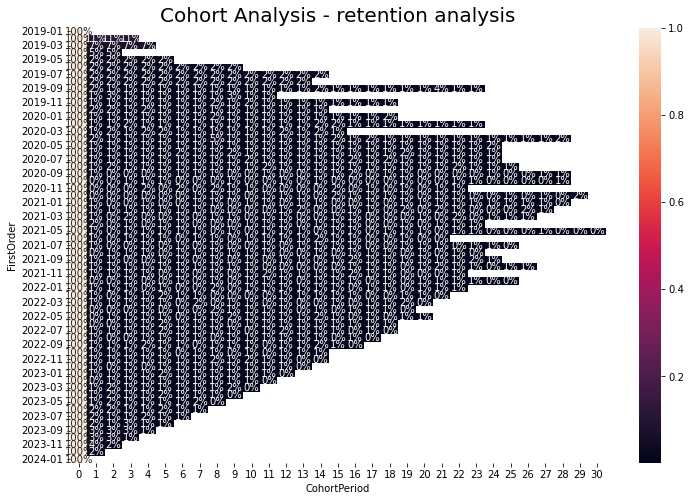

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns


#  시각화
plt.figure(figsize=(12, 8))
plt.title("Cohort Analysis - retention analysis", fontsize=20)

sns.heatmap(user_retention, annot=True, fmt=".0%")
plt.show()

## R (Revenue) 수익화
- 게임이라면 아이템, 스킨, 광고 시청료 등
- LTV, ARPPU, 전체매출 ,, 
- 고객의 평생 가치(LTV)를 지속적으로 높이고 유치 비용은 낮추기
- 사용자들이 우리 제품이나 서비스에 금액을 지불하여 매출 발생
- 이 단계에서는 단순히 매출 지표가 얼마이다 집계하는 것에서 끝나는 게 아니라 사용자들을 다양한 방식으로 그루핑하여 각 그룹에 맞는 운영, 수익화 전략을 세우는 고민을 하는 것
- 매출이 증가하거나 감소했을 때 그 원인이 가입 전환율이 좋아져서 인지, 고객들이 평균적으로 더 비싼 제품을 샀기 때문인지, 특정 고객 세그먼트에서 구매를 많이 했기 때문인지를 파악해보는 것

수익화와 관련된 측정 지표
- 매출액
- ARPU(객단가)
- 구매전환율
- LTV(Lifetime Value)


ARPU : Average Revenue Per User    
활동 사용자의 1인당 평균 결제 금액(매출)   
total Revenue / 중복을 제외한 순수 활동 사용자 수   
인당 평균 결제액    


ARPPU : Average Revenue Per Paying User    
유료 사용자 1인당 평균 결제 금액 = 돈을 실제로 지불한 사용자 / 중복을 제외한 순수 유료 사용자 수   
사용자가 허용할 수 있는 최대 가격선 파악하는 데에 도움 됨   
결제자 인당 평균 결제액    


ARPU = ARPPU * 전체 사용자 대비 유료 사용자의 비율   


Average Check : 구매 1회당 평균 금액, 구매 횟수를 분모로 둠 Revenue / Transaction   
사용자가 구매를 반복적으로 하면 할수록 ARPPU와 AC의 차이는 커지게 된다.   

*LTV(lifetime value: 한 명의 유저가 전체활동 기간동안 발생시키는 누적 수익   
(인당 평균매출-인당 평균비용 / 1-고객유지비율 + 할인율 ) - 고객 획득 비용      
: 고객유지비율, 할인율, 고객 획득 비용 알 수 없음 / 분석 불가    


*LTR(lifetime revenue :한 명의 유저가 전체활동 기간동안 발생시키는 누적 매출, 기준에 따라 달라지는 개념적인 지표로써 고객 획득 비용(CAC)보다 높아져야 긍정적 신호    


기간별로 고객 생애 매출이 증가하는 추이를 구한 후, 고객획득비용과 비교하면 서비스의 수익모델이 잘 동작하는지 확인할 수 있다. 건강하게 성장하는 서비스라면 LTR이 CAC를 빠르게 따라잡고 장기적으로 몇배수까지 높아져야 한다.

In [83]:
#Average Check
#df_order_items['sale_price'] = revenue

df_order_items[['created_at', 'shipped_at', 'delivered_at']] = df_order_items[['created_at', 'shipped_at', 'delivered_at']].apply(lambda col: pd.to_datetime(col))
orders = df_order_items.loc[df_order_items['status'] == 'Complete'].copy() 

#환불 기간이후 주문만 포함
after_return = orders['delivered_at'].max() - pd.DateOffset(days=14)
orders = orders[orders['delivered_at']<=after_return]

total_revenue = round(orders['sale_price'].sum(), 2)
total_transaction = len(orders)
average_check = round(total_revenue/total_transaction,2)


print("Revenue: ", total_revenue, " Transaction: ", total_transaction)
print("Average Check: ", average_check)

Revenue:  2565780.67  Transaction:  43132
Average Check:  59.49


평균적으로 구매 1회당 59.49$ 를 소비한다.

In [89]:
#ARPU (객단가)
#1인당 평균 결제 금액 
person = orders["user_id"].nunique()
ARPU = total_revenue / person
print("person",person)
print("ARPU",ARPU)

person 26270
ARPU 97.6696105824134


### RFM 분석
전체유저를 구매력에 따라 1~5티어로 나눠 매출, 구매자수, ARPPU 확인   
평균 사용자보다는 서비스에 대한 충성도가 높고 매출 기여도가 높은 사용자 층을 고려하는 것이 효과적이기 때문   
고객 세그먼트 기준을 나누기 위함    
- Recency : 얼마나 최근에 결제? 거래 최근성
- Frequency : 얼마나 자주 결제? 거래 빈도 
- Monetary : 얼마나 많은 금액을 결제? 거래 규모   


기준을 만들어서 점수를 주어 티어로 나눈다.

< 고객 세분화 >
1. VIP 고객 : 최근 구매, 자주, 큰 금액 소비
- 이들을 떠나지 않도록 붙잡기 위해서는 등급제 시스템 시도 


2. 충성 고객 : 최근 구매, 자주, 작은 금액 소비
- 구매금액만 높다면 VIP가 될 수 있는 고객군
- 구매 금액을 높이기 위해 일정 금액 이상 구매를 하는 경우 할인을 해준다거나, 사은품이나 무료 배송 등을 제공


3. 잠재 VIP 고객 : 최근 구매, 큰 금액 소비
4. 잠재 충성 고객 : 최근 구매, 적은 금액 소비
- 자주 구매하도록 유도한다면 높은 수익을 기대할 수 있는 고객군
- 자주 사이트에 방문할 수 있도록 하기 위해 출석체크 이벤트를 진행하여 포인트나 추첨 지급 


5. 놓치면 안되는 고객 : 예전, 자주, 큰 금액 소비
- 최근에 구매만 없을 뿐 충분히 VIP 고객이 될 수 있는 고객군
- 휴면예정 메시지를 날리거나 혹은 휴면을 해제할 경우 포인트나, 쿠폰, 상품등을 지급


6. 관심 필요 고객 : 예전, 자주, 적은 금액 소비
- 자주 구매를 하던 고객이 최근에 구매를 하지 않는다면 확인 필요
- 트래킹이 가능하다면 이들의 행동 데이터를 확인
- 체류 시간이 줄지는 않는지, 어느 단계에서 이탈하는지 체크
- CS 문의가 들어온 게 없는지, 경쟁사에서 이벤트를 진행하고 있는지 여부를 확인


7. 이탈 우려 고객 : 예전, 뜨문, 큰 금액 소비
- 구매 리스트 확인 (명품 혹은 전자제품과 같은 상품을 구매했을 가능성이 높음)
- 구매주기가 길지 않은 카테고리 -> 최근성과 빈도에서 저조한 등급
- 최근성이나 구매주기를 계산하는 기간의 구간을 넓게 설정하여 관리


8. 겨울잠 고객 : 예전, 뜨문, 적은 금액 소비
- 상대적으로 중요도가 가장 낮은 고객군
- 다른 고객군의 문제를 우선적으로 해결

In [67]:
#최근의 기준, 자주의 기준, 크고 작은 금액의 기준 필요

## R Referral (추천)
- 충성도 높은 사용자를 보이지 않는 브랜드 홍보자로 만들기, 리뷰작성, 공유하기, 친구초대
- 순 추천고객 지수(NPS)
- 어떻게 잠재 고객들에게 제품 추천 - 바이럴 지수(viral coefficient)
- 기존 사용자들이 추천이나 입소문을 통해 새로운 사용자들을 데려오는 것
- 친구 초대 기능
- 새로 유입된 사용자가 이탈하지 않도록 가입 단계나 온보딩 프로세스를 꼼꼼하게 잘 설계해야함


추천과 관련된 측정 지표
- 친구 초대 수
- SNS 공유수
- 댓글수 

마케팅 최적화를 위한 미디어 파트너별 유저들의 구매력

가입 시점에 따라 결제 전환율에 차이가 있는가?
특정 이벤트 경험 유무에 따라 결제 전환율에 차이가 있는가?
시간이나 요일, 계절이나 날씨 등 외부 변수에 따라 결제 전환율에 차이가 있는가?
사용자의 성별이나 나이 등 인구통계학적 정보에 따라 결제 전환율에 차이가 있는가?
이탈의 원인은 무엇인가?
전환된 사용자와 전환되지 않은 사용자는 무엇이 다른가?